# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Measure-Dynamic-Functional-Connectivity" data-toc-modified-id="Measure-Dynamic-Functional-Connectivity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Measure Dynamic Functional Connectivity</a></div><div class="lev2 toc-item"><a href="#Initialize-Environment" data-toc-modified-id="Initialize-Environment-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2 toc-item"><a href="#Gather-all-data-sets" data-toc-modified-id="Gather-all-data-sets-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gather all data sets</a></div><div class="lev2 toc-item"><a href="#Generate-processing-list" data-toc-modified-id="Generate-processing-list-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Generate processing list</a></div><div class="lev2 toc-item"><a href="#Submit-proc_list-to-qsub-as-jobs" data-toc-modified-id="Submit-proc_list-to-qsub-as-jobs-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Submit proc_list to qsub as jobs</a></div><div class="lev2 toc-item"><a href="#Continuously-monitor-queue-size-and-run-remaining-jobs" data-toc-modified-id="Continuously-monitor-queue-size-and-run-remaining-jobs-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Continuously monitor queue size and run remaining jobs</a></div><div class="lev1 toc-item"><a href="#Check-Adjacency" data-toc-modified-id="Check-Adjacency-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check Adjacency</a></div>

# Measure Dynamic Functional Connectivity

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    %reset
except:
    print 'NOT IPYTHON'

from __future__ import division

import os
import sys
import glob
import time

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

sys.path.append('/home/akhambhati/JagHome/hoth_research/Echobase')
import Echobase

rcParams = Echobase.Plotting.fig_format.update_rcparams(rcParams)

path_CoreData = '/data/jag/akhambhati/Remotes/CORE.RAM_Stim'
path_PeriphData = '/home/akhambhati/Procd_Data/RSRCH.RAM_Stim'
path_ExpData = path_PeriphData + '/e01-FuncNetw'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/akhambhati/Developer/miniconda2/envs/echobase/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Gather all data sets

In [2]:
path_list = glob.glob('{}/Stim_Trials/*.mat'.format(path_CoreData))
#path_list = glob.glob('{}/Baseline_DataFiles/*.mat'.format(path_CoreData))

data_list = []
for pth in path_list:    
    full_file = pth.split('/')[-1]    
    subj_id = full_file.split('.')[0]
    trial_id = full_file.split('.')[-2]

    chan_file = glob.glob('{}/Exp_Info/Channel_Info/{}.mat'.format(path_CoreData, subj_id))
    if len(chan_file) != 1:
        continue
    chan_file = chan_file[0]

    event_file = glob.glob('{}/Exp_Info/PS_Events/{}_events.mat'.format(path_CoreData, subj_id))
    if len(event_file) != 1:
        continue
    event_file = event_file[0]

    trial_lut_file = glob.glob('{}/Exp_Info/LUT_Trial_Events/{}_trial_lut.mat'.format(path_CoreData, subj_id))
    if len(trial_lut_file) != 1:
        continue
    trial_lut_file = trial_lut_file[0]
    
    data_list.append({'chan_path': chan_file,
                      'event_path': event_file,
                      'trial_lut_path': trial_lut_file,
                      'trial_id': trial_id.split('_')[-1],
                      'raw_path': pth,
                      'raw_name': '{}.{}'.format(subj_id, trial_id)})

## Generate processing list

In [3]:
def gen_proc_list():
    proc_item = []
    fin_items = []
    for d_item in data_list:
        chan_path = d_item['chan_path']
        event_path = d_item['event_path']
        trial_lut_path = d_item['trial_lut_path']  
        trial_id = d_item['trial_id']
        raw_path = d_item['raw_path']
        raw_name = d_item['raw_name']
        res_path = '{}/Adjacency.{}.npz'.format(path_ExpData, raw_name)

        if os.path.exists(res_path):
            fin_items.append(res_path)
            continue

        if os.path.exists('{}/Adjacency.{}.stdout'.format(path_ExpData, raw_name)):
            continue

        proc_item.append({'chan_path': chan_path,
                          'event_path': event_path,
                          'trial_lut_path': trial_lut_path,     
                          'trial_id': trial_id,
                          'raw_path': raw_path,
                          'raw_name': raw_name,
                          'res_path': res_path})
    print('There are {} jobs to process.'.format(len(proc_item)))
    print('There are {} jobs complete.'.format(len(fin_items)))
    
    return proc_item, fin_items

## Submit proc_list to qsub as jobs

In [4]:
def submit_job_file(proc_items):
    # Submit proc_item list as jobs to qsub
    job_file = open('./e01-Measure_Adjacency.job', 'w')
    job_file.write('#!/bin/bash\n\n')
    for pitem in proc_items:    
        stdout_path = '{}/Adjacency.{}.stdout'.format(path_ExpData, pitem['raw_name'])
        stderr_path = '{}/Adjacency.{}.stderr'.format(path_ExpData, pitem['raw_name'])

        py_str = './e01-Measure_Adjacency {} {} {} {} {} {}'.format(
            pitem['raw_path'], pitem['chan_path'], pitem['event_path'], pitem['trial_lut_path'], pitem['trial_id'], pitem['res_path'])

        cmd_str = 'qsub -cwd -o {} -e {} -l h_vmem=6.1G,s_vmem=6G -q all.q,basic.q'.format(stdout_path, stderr_path)

        job_file.write('{} {}\n'.format(cmd_str, py_str))
    job_file.close()

    !sh e01-Measure_Adjacency.job > job_dump
    !rm -r job_dump

## Continuously monitor queue size and run remaining jobs

In [ ]:
proc_item, fin_items = gen_proc_list()

while True:
    # Check status of queue
    n_queue_size = !qstat | wc -l
    n_queue_size = int(n_queue_size[0])
    
    if n_queue_size == 0:
        proc_item, fin_items = gen_proc_list()
        submit_job_file(np.random.permutation(proc_item))

    if len(proc_item) == 0:
        break

    time.sleep(60)

There are 3465 jobs to process.
There are 61448 jobs complete.
There are 3465 jobs to process.
There are 61448 jobs complete.


# Check Adjacency

Pre-Stimulus Adjacency


/home/akhambhati/Developer/miniconda2/envs/echobase/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/akhambhati/Developer/miniconda2/envs/echobase/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


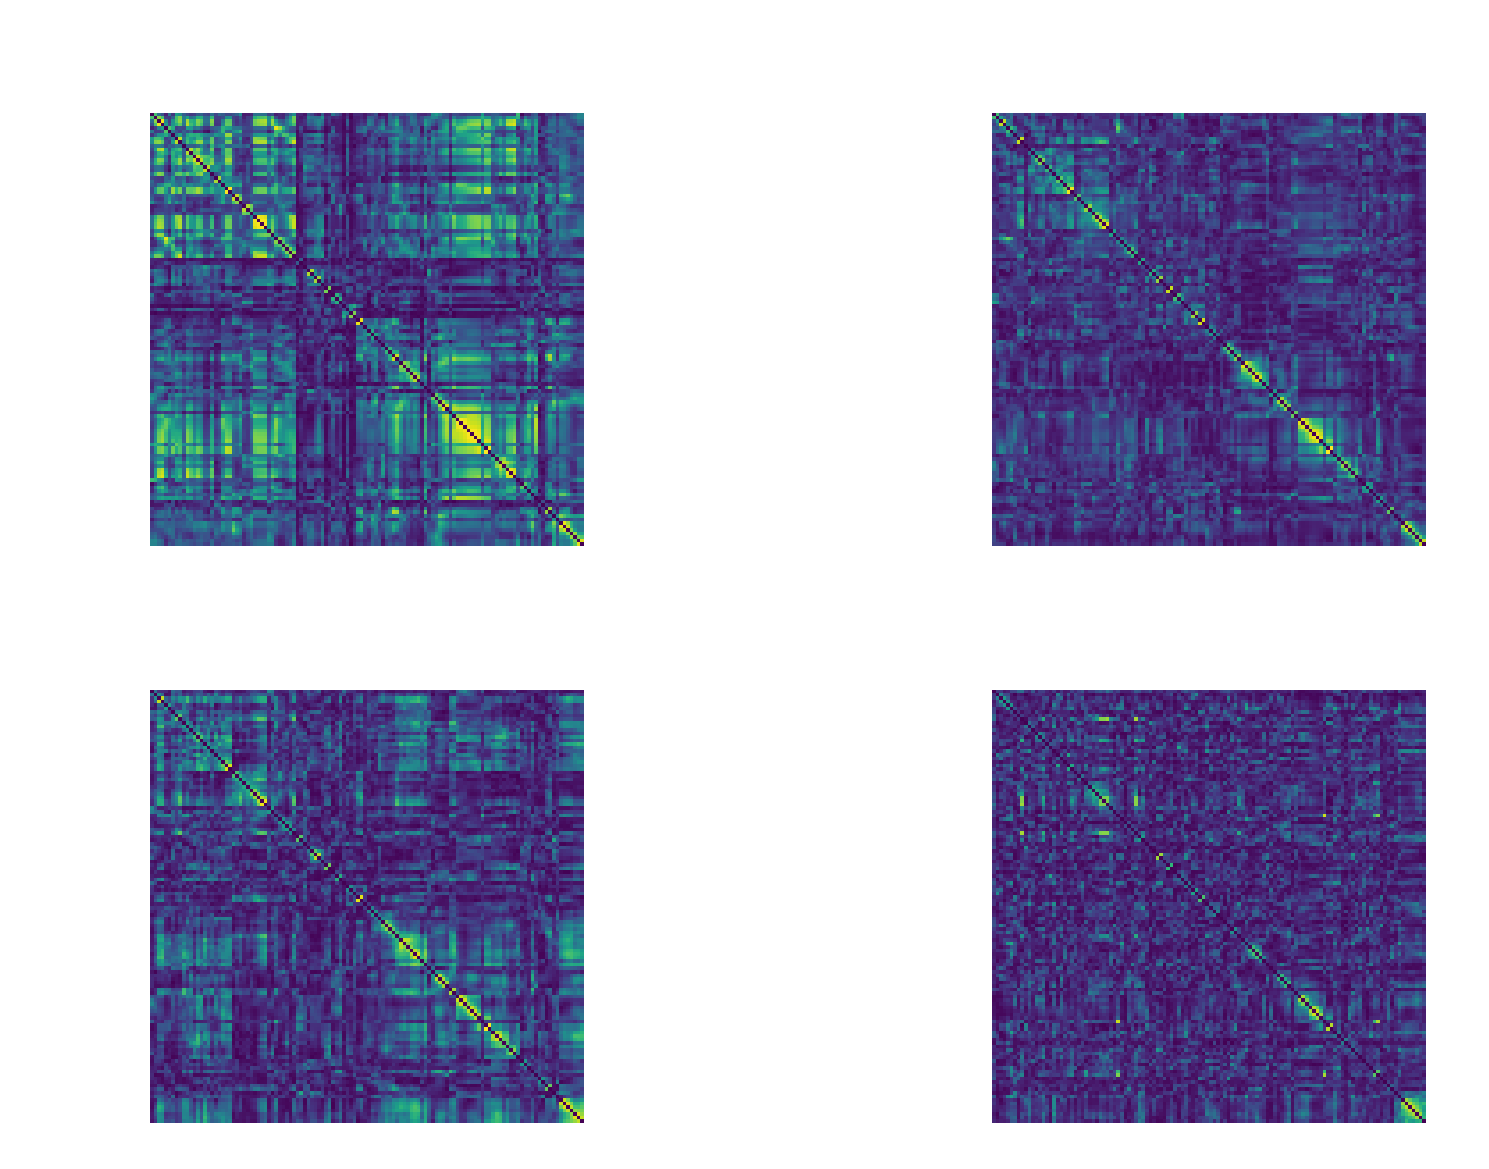

Post-Stimulus Adjacency


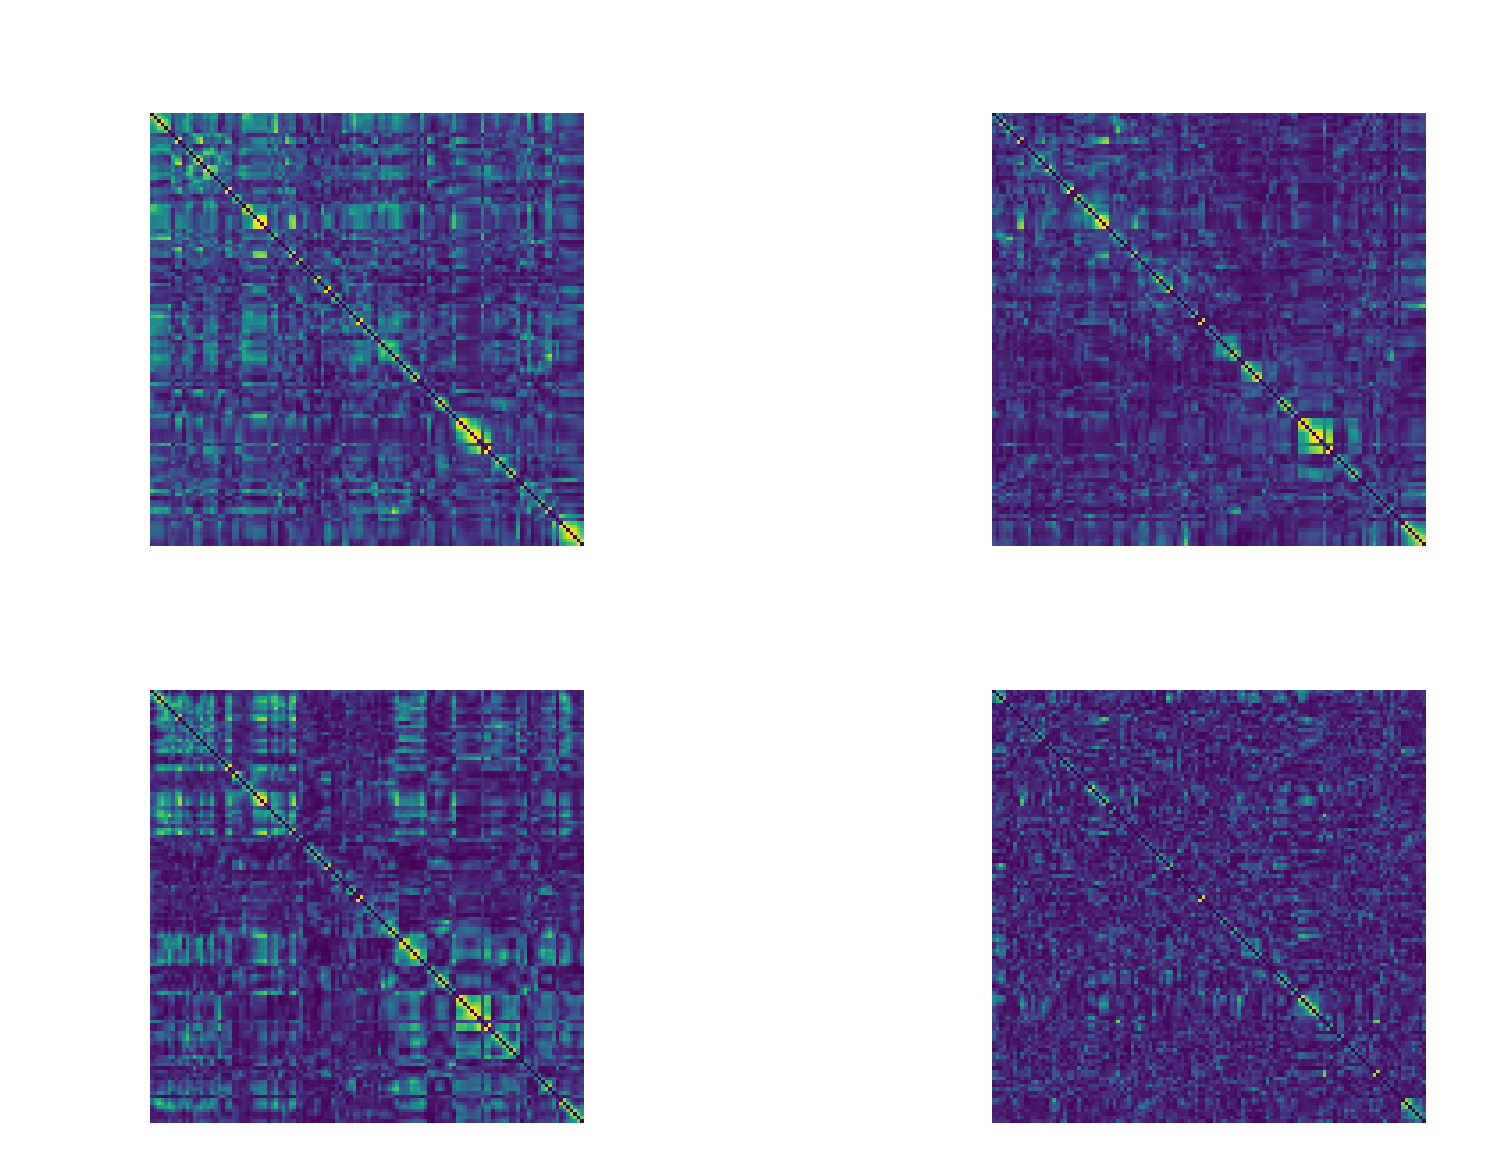

Delta Adjacency


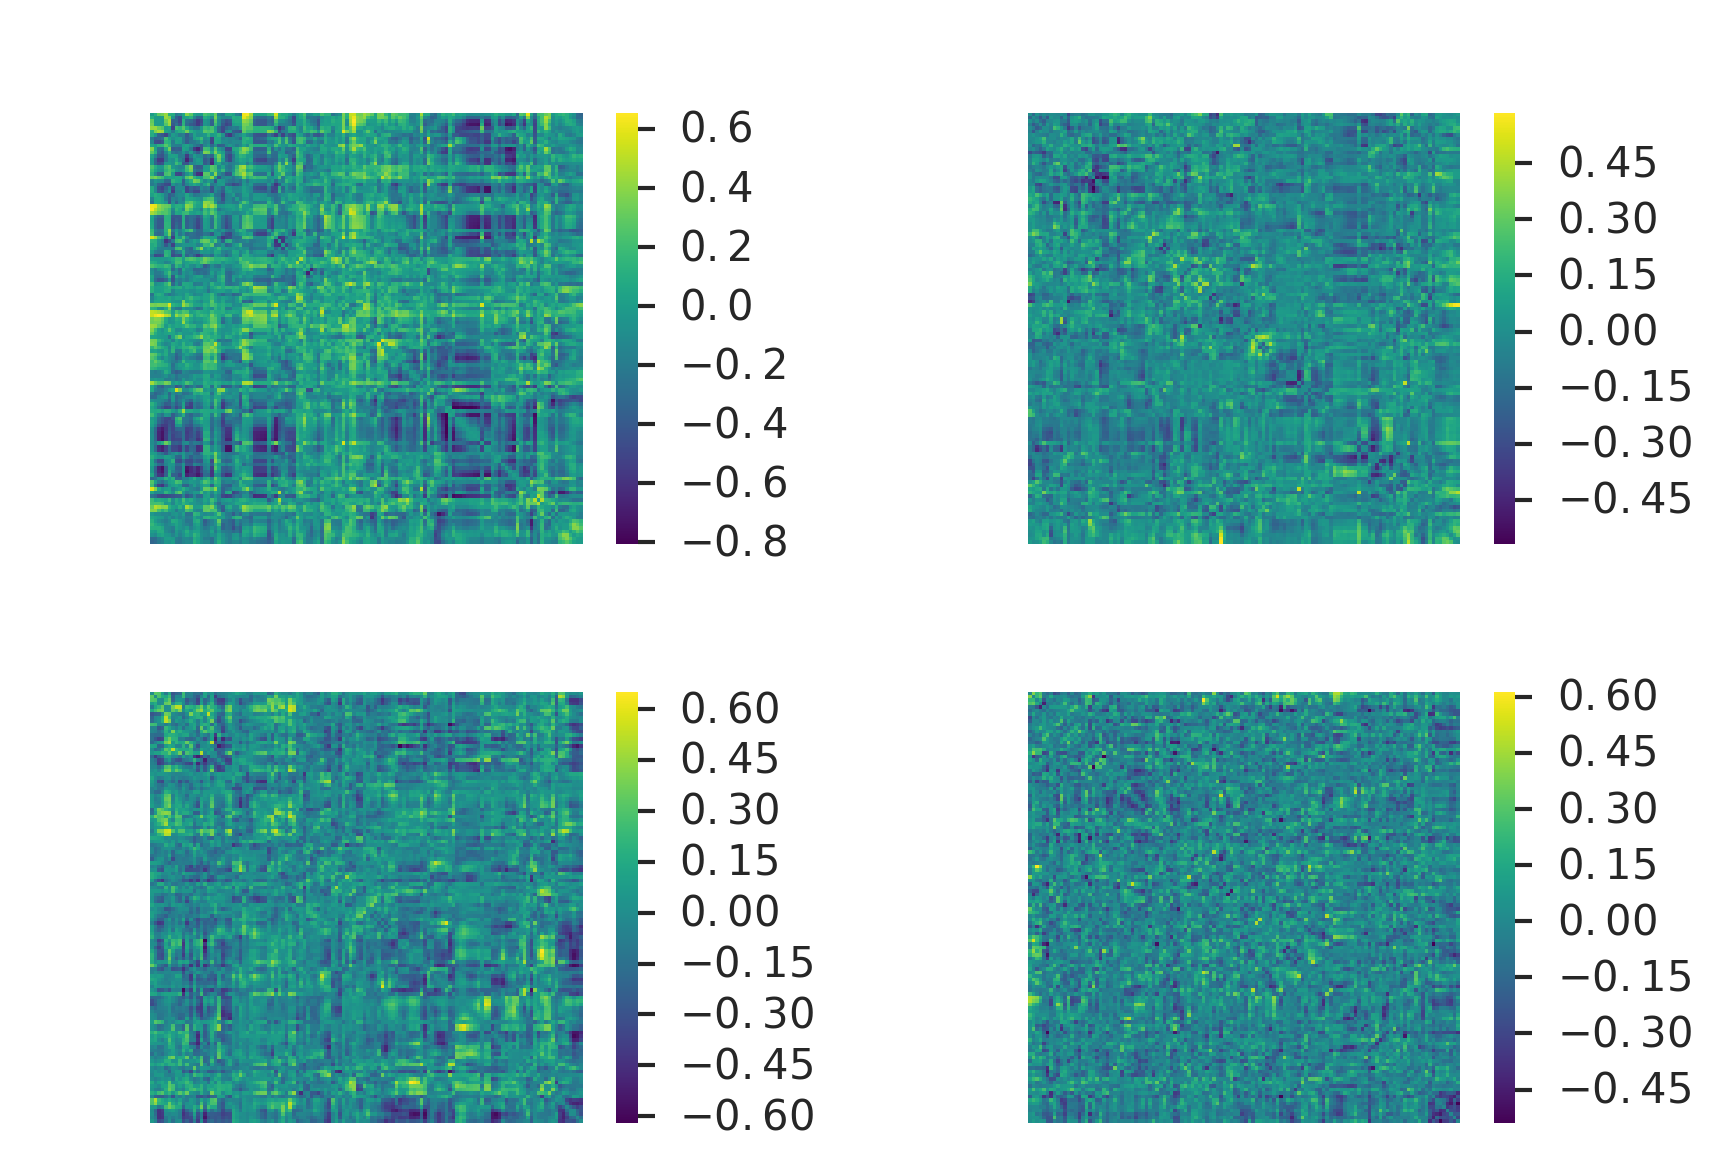

In [34]:
%matplotlib inline

# Check fin_items for a list of processed adjacency matrices
adj = np.load('/home/akhambhati/JagHome/hoth_research/rs-Net_Stim/Analysis_Notebooks/R1101T.Freq_100.Amp_0.25.Trial_402.npz')['adj'].item()

print('Pre-Stimulus Adjacency')
plt.figure()
ax = plt.subplot(2,2,1); ax.matshow(adj['Pre_Stim']['AlphaTheta'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,2); ax.matshow(adj['Pre_Stim']['Beta'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,3); ax.matshow(adj['Pre_Stim']['LowGamma'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,4); ax.matshow(adj['Pre_Stim']['HighGamma'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
plt.show()

print('Post-Stimulus Adjacency')
plt.figure()
ax = plt.subplot(2,2,1); ax.matshow(adj['Post_Stim']['AlphaTheta'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,2); ax.matshow(adj['Post_Stim']['Beta'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,3); ax.matshow(adj['Post_Stim']['LowGamma'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,4); ax.matshow(adj['Post_Stim']['HighGamma'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
plt.show()

print('Delta Adjacency')
plt.figure()
ax = plt.subplot(2,2,1); mat=ax.matshow(adj['Post_Stim']['AlphaTheta']-adj['Pre_Stim']['AlphaTheta'],
                                        cmap='viridis'); plt.colorbar(mat, ax=ax); ax.set_axis_off();
ax = plt.subplot(2,2,2); mat=ax.matshow(adj['Post_Stim']['Beta']-adj['Pre_Stim']['Beta'],
                                        cmap='viridis'); plt.colorbar(mat, ax=ax); ax.set_axis_off();
ax = plt.subplot(2,2,3); mat=ax.matshow(adj['Post_Stim']['LowGamma']-adj['Pre_Stim']['LowGamma'],
                                        cmap='viridis'); plt.colorbar(mat, ax=ax); ax.set_axis_off();
ax = plt.subplot(2,2,4); mat=ax.matshow(adj['Post_Stim']['HighGamma']-adj['Pre_Stim']['HighGamma'],
                                        cmap='viridis'); plt.colorbar(mat, ax=ax); ax.set_axis_off();
plt.show()